10. Applying SVM, Naive Bayes, Decision tree and KNN predict diabetes based on features set. Compare the four classification algorithms with performance metrics such as accuracy, recall, precision, F1- score. Also design the heat map confusion matrix for above algorithms and construct ROC curve for comparison.
Dataset: pima-indians-diabetes.data.csv


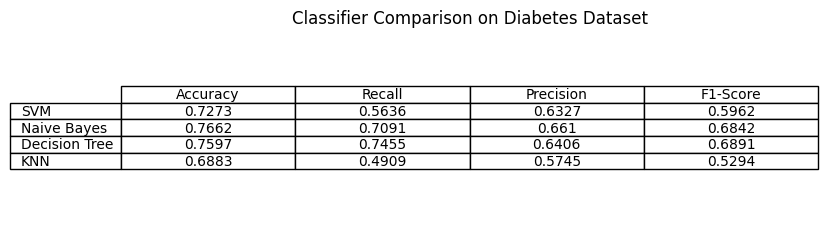

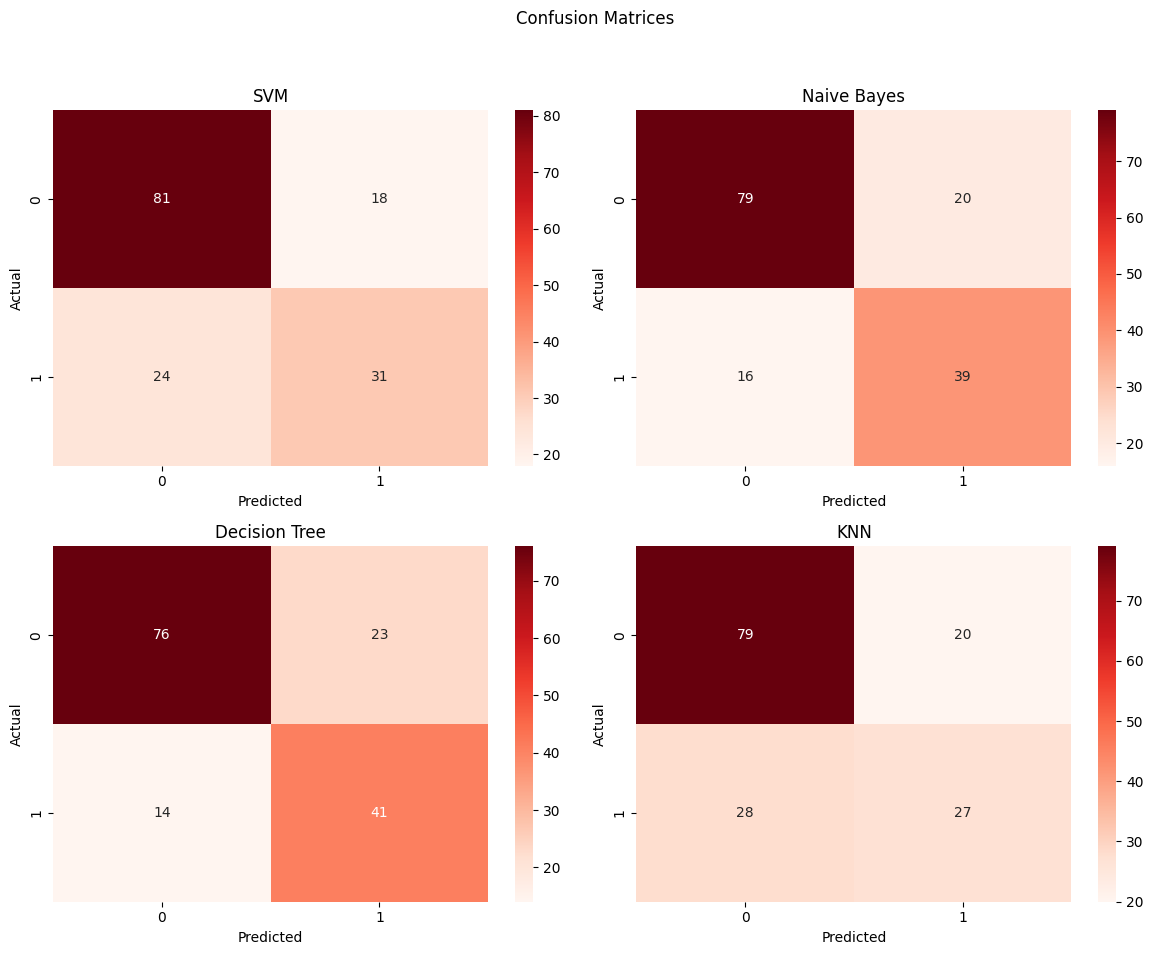

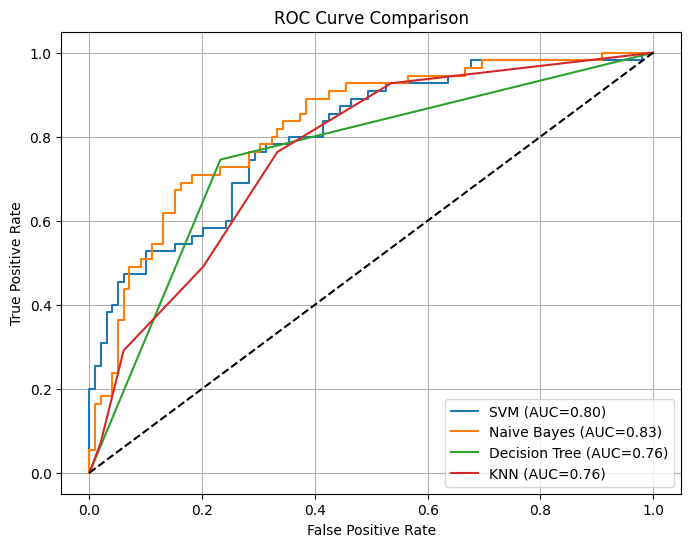

In [9]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, confusion_matrix, roc_curve, auc)
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load dataset
df = pd.read_csv('pima-indians-diabetes.data.csv', header=None)
X, y = df.iloc[:, :-1], df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(X), y, test_size=0.2, random_state=42)

# Models
models = {
    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier()
}

results, confs, rocs = {}, {}, {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    results[name] = [
        accuracy_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        f1_score(y_test, y_pred)
    ]
    confs[name] = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    rocs[name] = (fpr, tpr, auc(fpr, tpr))

# Metrics table
metrics_df = pd.DataFrame(results, index=['Accuracy', 'Recall', 'Precision', 'F1-Score']).T.round(4)
fig, ax = plt.subplots(figsize=(9, 2.5))
ax.axis('off')
t = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns,
             rowLabels=metrics_df.index, loc='center', cellLoc='center')
t.auto_set_font_size(False); t.set_fontsize(10)
plt.title("Classifier Comparison on Diabetes Dataset")
plt.savefig("diabetes_metrics_table.png", dpi=300, bbox_inches='tight')
plt.show()

# Confusion Matrix Heatmaps
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()
for i, (name, cm) in enumerate(confs.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', ax=axs[i])
    axs[i].set_title(name); axs[i].set_xlabel('Predicted'); axs[i].set_ylabel('Actual')
plt.suptitle("Confusion Matrices")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("diabetes_confusion_matrices.png", dpi=300)
plt.show()

# ROC Curve
plt.figure(figsize=(8,6))
for name, (fpr, tpr, auc_val) in rocs.items():
    plt.plot(fpr, tpr, label=f'{name} (AUC={auc_val:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(); plt.grid(True)
plt.savefig("diabetes_roc_comparison.png", dpi=300)
plt.show()


In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, make_scorer

# Define SVM and parameter grid
svm = SVC(probability=True)
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'linear']
}

# Use AUC as scoring metric
grid = GridSearchCV(svm, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# Evaluate on test set
best_model = grid.best_estimator_
y_prob = best_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_prob)

print("Best Parameters:", grid.best_params_)
print("Test AUC Score:", round(test_auc, 4))


Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Test AUC Score: 0.8149


In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

# Function to tune and evaluate a model
def tune_model(name, model, param_grid):
    print(f"\n🔍 Tuning {name}...")
    grid = GridSearchCV(model, param_grid, scoring='roc_auc', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    y_prob = best_model.predict_proba(X_test)[:, 1]
    test_auc = roc_auc_score(y_test, y_prob)
    print(f"Best Parameters for {name}: {grid.best_params_}")
    print(f"{name} Test AUC: {test_auc:.4f}")
    return best_model, test_auc

# Param grids
param_grids = {
    'SVM': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 0.01],
        'kernel': ['rbf', 'linear']
    },
    'Naive Bayes': {
        # No hyperparameters to tune for GaussianNB directly
    },
    'Decision Tree': {
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
}

# Tune each model
models = {
    'SVM': SVC(probability=True),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier()
}

best_models = {}
for name, model in models.items():
    if param_grids.get(name):  # Has params
        best_model, auc_score = tune_model(name, model, param_grids[name])
    else:  # No tuning for Naive Bayes
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_prob)
        print(f"\n✅ Naive Bayes Test AUC: {auc_score:.4f}")
        best_model = model
    best_models[name] = (best_model, auc_score)



🔍 Tuning SVM...
Best Parameters for SVM: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
SVM Test AUC: 0.8149

✅ Naive Bayes Test AUC: 0.8253

🔍 Tuning Decision Tree...
Best Parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
Decision Tree Test AUC: 0.8038

🔍 Tuning KNN...
Best Parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
KNN Test AUC: 0.7521
